In [1]:
from IPython.display import clear_output

In [2]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

## Contents

Today we'll attempt to create a number image generator through auto encoders. Here's the technique

1. The model has 2 parts, an encoder and a decoder
2. The encoder takes number image (mnist) and converts it into an embedding/encoding of specified size (output of encoder last layer). by passing it through multiple linear layers.
3. The decoder then takes that encoding and attempts to re-create the original image
4. During training, our cost function is the difference between generated image and original image. we'll use MSE Loss for this
5. Once the training is complete, we'll create our own embeddings of specified size ourselves and run it through the decoder to generate images


Note: In this notebook we'll limit ourselves to Linear Layers or BatchNorm's only (and activations). Which means NO CNN, attention, or anything fancier. For this reason, the performance might be questionable. What we wanna see is the model trying to capture the pattern?

You need to know:

1. **pytorch** (for impelementation)
2. a bit of **torch dataloaders and datasets** (not necessary but helps understanding how we're loading data)
3. A little bit of **matplotlib** (for result and training trajectory visualization)

In [3]:
batch_size = 64

train_transforms = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])

train_data = MNIST(root='./datasets', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 55347349.42it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40951891.08it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41070921.48it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23872843.07it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [7]:
class AutoEncoderGenerator(nn.Module):

  def __init__(self, dim_z):
    super().__init__()
    self.Encoder = nn.Sequential(

        nn.Linear(28*28, 512),
        nn.LeakyReLU(),
        nn.BatchNorm1d(512),

        nn.Linear(512, 256),
        nn.LeakyReLU(),
        nn.BatchNorm1d(256),



        nn.Linear(256, dim_z),
        nn.Tanh(),
      )


    self.Decoder = nn.Sequential(
        nn.Linear(dim_z, 256),
        nn.LeakyReLU(),

        nn.Linear(256, 512),
        nn.LeakyReLU(),

        nn.Linear(512, 1024),
        nn.LeakyReLU(),

        nn.Linear(1024, 28*28),
        nn.Sigmoid()
      )

  def forward(self, x):

    original_shape = x.shape
    x = torch.flatten(x, start_dim=1)# the dimention here is reffer to one column vector i think so

    z = self.Encoder(x)
    x = self.Decoder(z)

    x = x.view(original_shape)

    return x


In [5]:
dim_z = 128
model = AutoEncoderGenerator(dim_z=dim_z)

In [6]:
summary(model, (1, 28, 28), device='cpu')#the feature of using pytourch is you can pick between using cpu or gpu

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
         LeakyReLU-2                  [-1, 512]               0
       BatchNorm1d-3                  [-1, 512]           1,024
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
       BatchNorm1d-6                  [-1, 256]             512
            Linear-7                  [-1, 128]          32,896
              Tanh-8                  [-1, 128]               0
            Linear-9                  [-1, 256]          33,024
        LeakyReLU-10                  [-1, 256]               0
           Linear-11                  [-1, 512]         131,584
        LeakyReLU-12                  [-1, 512]               0
           Linear-13                 [-1, 1024]         525,312
        LeakyReLU-14                 [-

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

num_epochs = 20
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [9]:
train_losses = []

for i in range(num_epochs):

  epoch_weighted_loss = 0
  for (X, _) in train_loader:

    X = X.to(device)

    Xhat = model(X)  # Xhat because we're trying to have the model regenerate what's fed to it (X)

    optimizer.zero_grad()
    loss = criterion(Xhat, X)
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += loss.item()*len(X)

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)

  print(f'epoch {i}/{num_epochs}, loss = {epoch_loss}')

  train_losses.append(epoch_loss)

epoch 0/8, loss = 0.006915736674020688
epoch 1/8, loss = 0.0067972731880843636
epoch 2/8, loss = 0.006701123844087124
epoch 3/8, loss = 0.006632133753846089
epoch 4/8, loss = 0.006552385297169288
epoch 5/8, loss = 0.0064769401793678604
epoch 6/8, loss = 0.006397004047036171
epoch 7/8, loss = 0.006316244691113631


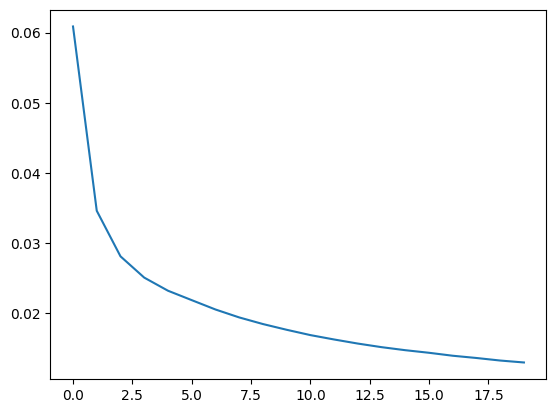

In [ ]:
plt.plot(train_losses)

In [10]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im, cmap="gray")
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()

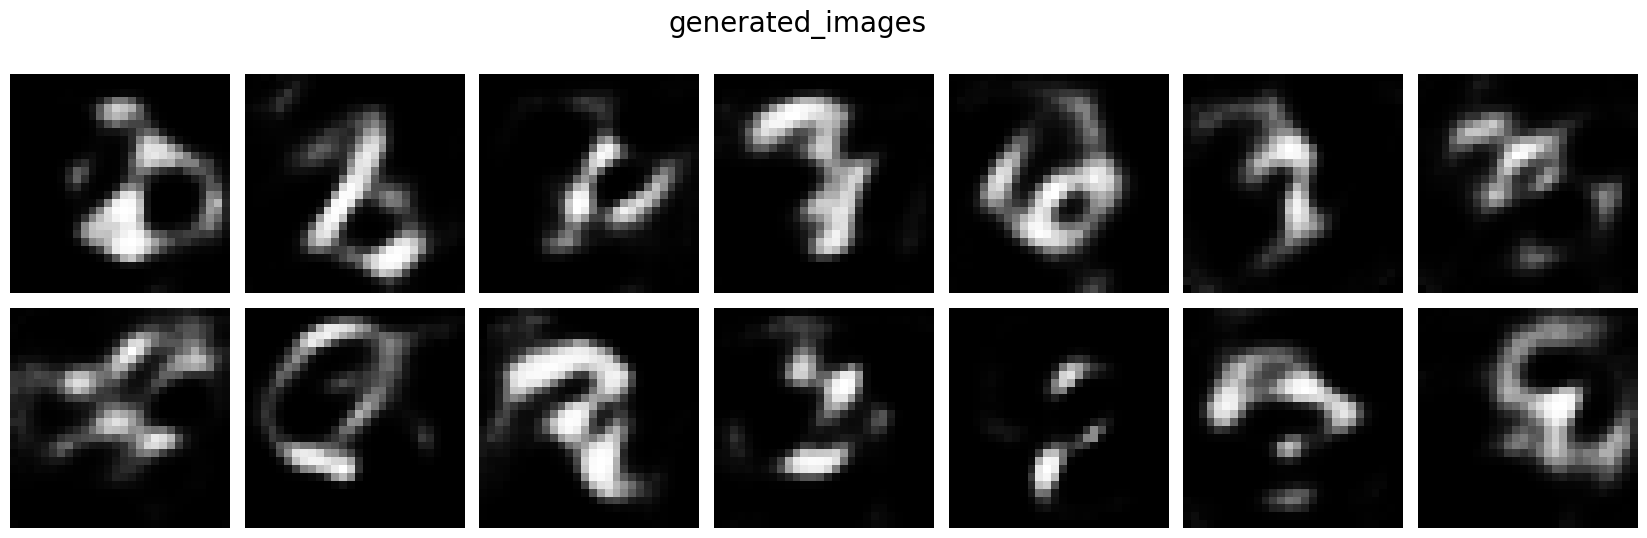

In [ ]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder

rows, cols = 2, 7
sample_encodings = (torch.rand(rows*cols, dim_z).to(device) - 0.5) * 2 # encoding space: [-1,1)
with torch.no_grad():
  generations = model.Decoder(sample_encodings).cpu()
  generations = generations.reshape(-1, 28, 28, 1)
display_image_grid(generations, rows, cols, "generated_images")

The images aren't too fancy but we can see it's trying to learn.
In a few images we can also guess the number it's trying to generate